In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sales_dataset.csv to sales_dataset.csv


**Imports**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
import pickle
from plotly.subplots import make_subplots

Loading the data

In [ ]:
df = pd.read_csv("sales_dataset.csv")
df

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,South Africa,Fruits,Offline,M,2012-07-27,443368995,2012-07-28,611265,38.26,12.67,23386998.90,7744727.55,15642271.35
1,Middle East and North Africa,Morocco,Clothes,Online,M,2013-09-14,667593514,2013-10-19,545518,145.65,79.81,79454696.70,43537791.58,35916905.12
2,Australia and Oceania,Papua New Guinea,Meat,Offline,M,2015-05-15,940995585,2015-06-04,326908,186.66,94.10,61020647.28,30762042.80,30258604.48
3,Sub-Saharan Africa,Djibouti,Clothes,Offline,H,2017-05-17,880811536,2017-07-02,431659,144.86,66.93,62530122.74,28890936.87,33639185.87
4,Europe,Slovakia,Beverages,Offline,L,2016-10-26,174590194,2016-12-04,625973,15.86,6.30,9927931.78,3943629.90,5984301.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994594,Sub-Saharan Africa,Senegal,Baby Food,Offline,L,2010-11-06,575470578,2010-12-11,317898,80.07,28.90,25454092.86,9187252.20,16266840.66
994595,Central America and the Caribbean,Panama,Office Supplies,Offline,C,2015-01-12,766942107,2015-03-01,363273,106.49,43.83,38684941.77,15922255.59,22762686.18
994596,Europe,Norway,Office Supplies,Online,M,2011-10-25,685472047,2011-12-05,367562,101.90,46.38,37454567.80,17047525.56,20407042.24
994597,Europe,Montenegro,Beverages,Offline,M,2010-10-31,946734225,2010-12-08,663167,15.08,6.87,10000558.36,4555957.29,5444601.07


In [ ]:
df.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
      dtype='object')

EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994599 entries, 0 to 994598
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Region          994599 non-null  object 
 1   Country         994599 non-null  object 
 2   Item Type       994599 non-null  object 
 3   Sales Channel   994599 non-null  object 
 4   Order Priority  994599 non-null  object 
 5   Order Date      994599 non-null  object 
 6   Order ID        994599 non-null  int64  
 7   Ship Date       994599 non-null  object 
 8   Units Sold      994599 non-null  int64  
 9   Unit Price      994599 non-null  float64
 10  Unit Cost       994599 non-null  float64
 11  Total Revenue   994599 non-null  float64
 12  Total Cost      994599 non-null  float64
 13  Total Profit    994599 non-null  float64
dtypes: float64(5), int64(2), object(7)
memory usage: 106.2+ MB


In [ ]:
df.describe()

,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
count,9.945990e+05,9.945990e+05,994599.000000,994599.000000,9.945990e+05,9.945990e+05,9.945990e+05
mean,5.493688e+08,4.477692e+05,92.474857,46.323549,3.609370e+07,1.773078e+07,1.836292e+07
std,2.599414e+08,1.508199e+05,80.551447,50.328235,2.969549e+07,1.875209e+07,1.170984e+07
min,1.000012e+08,9.300100e+04,13.500000,3.830000,2.888710e+06,7.636766e+05,1.850556e+06
25%,3.239774e+08,3.439005e+05,27.270000,6.290000,1.400434e+07,3.785686e+06,1.006361e+07
50%,5.487189e+08,4.144380e+05,74.650000,33.120000,2.660794e+07,1.145205e+07,1.464189e+07
75%,7.746139e+08,5.144585e+05,109.970000,66.680000,4.680453e+07,2.462405e+07,2.359062e+07
max,9.999999e+08,1.759186e+06,330.000000,227.310000,2.278949e+08,1.432110e+08,1.091599e+08


In [ ]:
df.describe(include='object')

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Ship Date
count,994599,994599,994599,994599,994599,994599,994599
unique,7,184,12,2,4,2767,2817
top,Sub-Saharan Africa,Panama,Fruits,Offline,C,2016-11-25,2015-08-14
freq,259953,5606,83111,497576,249001,426,419


Feature Enginnering

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [ ]:
df = df.sort_values('Order Date').reset_index(drop=True)

df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['DayOfWeek'] = df['Order Date'].dt.dayofweek
df['Quarter'] = df['Order Date'].dt.quarter
df['DayOfMonth'] = df['Order Date'].dt.day
df['WeekOfYear'] = df['Order Date'].dt.isocalendar().week

df['Shipping_Days'] = (df['Ship Date'] - df['Order Date']).dt.days

In [ ]:
for window in [7, 30]:
    df[f'Rolling_{window}d_Avg_Revenue'] = df.groupby('Region')['Total Revenue'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())
    df[f'Rolling_{window}d_Avg_Units'] = df.groupby('Region')['Units Sold'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())

In [ ]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

df

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,...,Month,DayOfWeek,Quarter,DayOfMonth,WeekOfYear,Shipping_Days,Rolling_7d_Avg_Revenue,Rolling_7d_Avg_Units,Rolling_30d_Avg_Revenue,Rolling_30d_Avg_Units
0,Australia and Oceania,Federated States of Micronesia,Household,Online,H,2010-01-01,483460080,2010-01-17,374104,271.18,...,1,4,1,1,53,16,1.014495e+08,374104.000000,1.014495e+08,374104.000000
1,Sub-Saharan Africa,Benin,Fruits,Offline,M,2010-01-01,745230376,2010-01-04,746270,38.56,...,1,4,1,1,53,3,2.877617e+07,746270.000000,2.877617e+07,746270.000000
2,Asia,Singapore,Personal Care,Online,M,2010-01-01,871963250,2010-02-07,366317,65.99,...,1,4,1,1,53,37,2.417326e+07,366317.000000,2.417326e+07,366317.000000
3,Europe,Russia,Clothes,Online,H,2010-01-01,836816442,2010-02-19,482837,153.20,...,1,4,1,1,53,49,7.397063e+07,482837.000000,7.397063e+07,482837.000000
4,Europe,Latvia,Cosmetics,Offline,L,2010-01-01,853307521,2010-01-19,404100,92.21,...,1,4,1,1,53,18,5.561634e+07,443468.500000,5.561634e+07,443468.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994594,Asia,Indonesia,Baby Food,Online,L,2017-07-29,666396176,2017-08-03,282062,78.62,...,7,5,3,29,30,5,2.760261e+07,476843.000000,2.880111e+07,471857.300000
994595,Asia,Vietnam,Snacks,Offline,L,2017-07-29,938753688,2017-09-07,596919,18.43,...,7,5,3,29,30,40,2.106009e+07,519447.142857,2.862027e+07,484986.433333
994596,Asia,Bhutan,Clothes,Online,C,2017-07-29,992792260,2017-09-14,409409,137.54,...,7,5,3,29,30,47,2.542115e+07,481337.285714,3.009490e+07,478544.633333
994597,Asia,Taiwan,Personal Care,Offline,C,2017-07-29,365149772,2017-08-29,318815,73.91,...,7,5,3,29,30,31,2.507939e+07,476060.000000,3.055795e+07,468002.933333


Handling Duplicates

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

Encoding

In [ ]:
le_dict = {}
for col in ['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority']:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    le_dict[col] = le


Checking if there is sales with loss

In [ ]:
df['Is_Loss'] = (df['Total Profit'] < 0).astype(int)
df['Is_Loss'].sum()

np.int64(0)

In [ ]:
df.drop(columns=['Is_Loss'], inplace=True)


Correlation Matrix

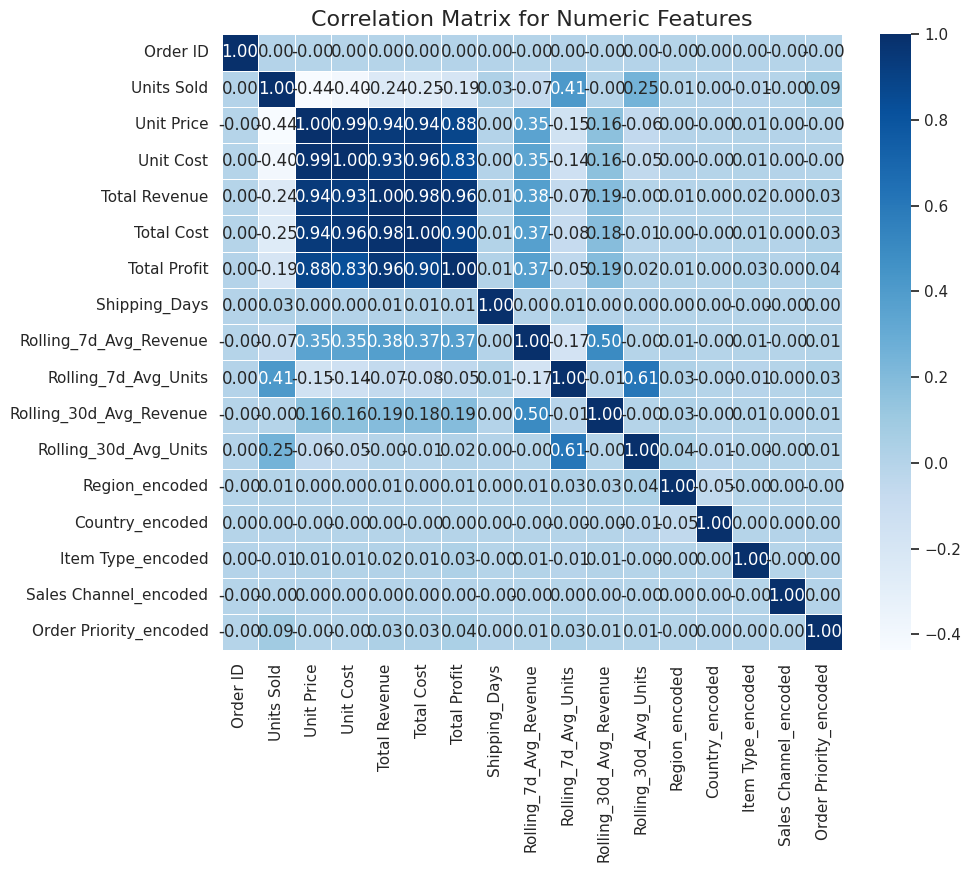

In [ ]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Numeric Features', size=16)
plt.show()


In [ ]:
print(df['Order Date'].min())
print(df['Order Date'].max())

2010-01-01 00:00:00
2017-07-29 00:00:00


In [ ]:
dfv = df[df['Item Type'] == 'Vegetables'].copy()
dff = df[df['Item Type'] == 'Fruits'].copy()


In [ ]:
df.drop(columns=['Region', 'Country', 'Item Type'], inplace=True)


In [ ]:
df.columns

Index(['Sales Channel', 'Order Priority', 'Order Date', 'Order ID',
       'Ship Date', 'Units Sold', 'Unit Price', 'Unit Cost', 'Total Revenue',
       'Total Cost', 'Total Profit', 'Year', 'Month', 'DayOfWeek', 'Quarter',
       'DayOfMonth', 'WeekOfYear', 'Shipping_Days', 'Rolling_7d_Avg_Revenue',
       'Rolling_7d_Avg_Units', 'Rolling_30d_Avg_Revenue',
       'Rolling_30d_Avg_Units', 'Region_encoded', 'Country_encoded',
       'Item Type_encoded', 'Sales Channel_encoded', 'Order Priority_encoded'],
      dtype='object')

In [ ]:
rename_map = {
    'Year': 'Year',
    'Month': 'Month',
    'Day': 'Day',
    'DayOfWeek': 'DayOfWeek',
    'DayOfMonth': 'Day',
    'WeekOfYear': 'Week',
    'Shipping_Days': 'Shipping Delay',

    'Region_encoded': 'Region_Encoded',
    'Country_encoded': 'Country_Encoded',
    'Item Type_encoded': 'Item_Type_Encoded',
    'Sales Channel_encoded': 'Sales_Channel_Encoded',
    'Order Priority_encoded': 'Order_Priority_Encoded',

    'Rolling_7d_Avg_Revenue': 'Rolling_7D_rev',
    'Rolling_30d_Avg_Revenue': 'Rolling_1M_rev',
    'Rolling_7d_Avg_Units': 'Rolling_7D',
    'Rolling_30d_Avg_Units': 'Rolling_1M',

    'Lag_1': 'Lag_1D',
    'Lag_3': 'Lag_3D',
    'Lag_6': 'Lag_6D',
    'Lag_12': 'Lag_12D',

    'Rolling_3M': 'Rolling_3M',
    'Rolling_6M': 'Rolling_6M',
    'Rolling_12M': 'Rolling_12M',

    'Unit Price': 'Unit Price',
    'Unit Cost': 'Unit Cost',
    'IsWeekend': 'IsWeekend',
    'Season_Encoded': 'Season_Encoded'
}


In [ ]:
# df is your current model's DataFrame
df = df.rename(columns={col: rename_map[col] for col in df.columns if col in rename_map})


**Prepare train-test split based on time**
:Training on the first 5 years (2010-2015) and testing on the last two years (2015-2017)


In [ ]:

train_end_date = df['Order Date'].max() - pd.DateOffset(years=2)
train_df = df[df['Order Date'] <= train_end_date]
test_df = df[df['Order Date'] > train_end_date]

Defining the X and Y features

In [ ]:
feature_cols = [
    'Year',
    'Month',
    'DayOfWeek',
    'Quarter',
    'Day',
    'Week',
    'Shipping Delay',
    'Region_Encoded',
    'Country_Encoded',
    'Item_Type_Encoded',
    'Sales_Channel_Encoded',
    'Order_Priority_Encoded',
    'Rolling_7D_rev',
    'Rolling_1M_rev'
]


**Modeling**

Working on one item type at a time

In [ ]:
dfv.drop(columns=['Rolling_7d_Avg_Revenue', 'Rolling_7d_Avg_Units', 'Rolling_30d_Avg_Revenue', 'Rolling_30d_Avg_Units'], inplace=True)
dff.drop(columns=['Rolling_7d_Avg_Revenue', 'Rolling_7d_Avg_Units', 'Rolling_30d_Avg_Revenue', 'Rolling_30d_Avg_Units'], inplace=True)

In [ ]:
for window in [7, 30]:
    dfv[f'Rolling_{window}d_Avg_Revenue'] = dfv.groupby('Region')['Total Revenue'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())
    dfv[f'Rolling_{window}d_Avg_Units'] = dfv.groupby('Region')['Units Sold'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())

<ipython-input-81-c7970184a0cd>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-81-c7970184a0cd>:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-81-c7970184a0cd>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-81-c7970184a0cd>:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

In [ ]:
for window in [7, 30]:
    dff[f'Rolling_{window}d_Avg_Revenue'] = dff.groupby('Region')['Total Revenue'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())
    dff[f'Rolling_{window}d_Avg_Units'] = dff.groupby('Region')['Units Sold'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())

<ipython-input-82-7390dee93057>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-82-7390dee93057>:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-82-7390dee93057>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-82-7390dee93057>:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

In [ ]:

lag_periods = [1, 7, 30, 90, 180, 365]

# Apply lag transformation grouped by 'Region'
for lag in lag_periods:
    dfv[f'Lag_{lag}d_Units_Sold'] = dfv.groupby('Region')['Units Sold'].shift(lag)


<ipython-input-83-7c5ed5de1996>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-83-7c5ed5de1996>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-83-7c5ed5de1996>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-83-7c5ed5de1996>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

In [ ]:

lag_periods = [1, 7, 30, 90, 180, 365]

# Apply lag transformation grouped by 'Region'
for lag in lag_periods:
    dff[f'Lag_{lag}d_Units_Sold'] = dff.groupby('Region')['Units Sold'].shift(lag)

<ipython-input-84-de24b0b9430f>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-84-de24b0b9430f>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-84-de24b0b9430f>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-84-de24b0b9430f>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

In [ ]:
for col in ['Lag_1d_Units_Sold', 'Lag_7d_Units_Sold', 'Lag_30d_Units_Sold', 'Lag_90d_Units_Sold',
            'Lag_180d_Units_Sold', 'Lag_365d_Units_Sold']:
    dfv[col] = dfv.groupby('Region')[col].transform(lambda x: x.fillna(x.mean()))

<ipython-input-85-e51c3743f442>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
for col in ['Lag_1d_Units_Sold', 'Lag_7d_Units_Sold', 'Lag_30d_Units_Sold', 'Lag_90d_Units_Sold',
            'Lag_180d_Units_Sold', 'Lag_365d_Units_Sold']:
    dff[col] = dff.groupby('Region')[col].transform(lambda x: x.fillna(x.mean()))

<ipython-input-86-8ef10db90640>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
dfv['Profit Margin'] = dfv['Total Profit'] / dfv['Total Revenue']
dfv['Markup'] = (dfv['Unit Price'] - dfv['Unit Cost']) / dfv['Unit Cost']

In [ ]:
dff['Profit Margin'] = dff['Total Profit'] / dff['Total Revenue']
dff['Markup'] = (dff['Unit Price'] - dff['Unit Cost']) / dff['Unit Cost']

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=dff['Order Date'], y=dff['Units Sold'],
    mode='lines', name='Units Sold'
))

fig.add_trace(go.Scatter(
    x=dff['Order Date'], y=dff['Rolling_30d_Avg_Units'],
    mode='lines', name='30d Rolling Avg', line=dict(dash='dash')
))

fig.update_layout(
    title='Units Sold Over Time',
    xaxis_title='Order Date',
    yaxis_title='Units Sold',
    template='plotly_white'
)

fig.show()

In [ ]:
region_units = dff.groupby('Region')['Units Sold'].sum().reset_index()

fig = px.bar(region_units, x='Region', y='Units Sold',
             title='Total Units Sold by Region for Fruits',
             color='Units Sold',
             template='plotly_white')

fig.show()

In [ ]:
region_uni = dfv.groupby('Region')['Units Sold'].sum().reset_index()

fig = px.bar(region_uni, x='Region', y='Units Sold',
             title='Total Units Sold by Region for Vegetables',
             color='Units Sold',
             template='plotly_dark')

fig.show()

In [ ]:
dfv.drop(columns=['Region', 'Country', 'Item Type'], inplace=True)
dff.drop(columns=['Region', 'Country', 'Item Type'], inplace=True)

In [ ]:
rename_map = {
    'Year': 'Year',
    'Month': 'Month',
    'DayOfWeek': 'DayOfWeek',
    'Quarter': 'Quarter',
    'DayOfMonth': 'Day',
    'WeekOfYear': 'Week',
    'Shipping_Days': 'Shipping Delay',

    'Region_encoded': 'Region_Encoded',
    'Country_encoded': 'Country_Encoded',
    'Item Type_encoded': 'Item_Type_Encoded',
    'Sales Channel_encoded': 'Sales_Channel_Encoded',
    'Order Priority_encoded': 'Order_Priority_Encoded',

    'Rolling_7d_Avg_Units': 'Rolling_7D',
    'Rolling_30d_Avg_Units': 'Rolling_1M',

    'Unit Price': 'Unit Price',

    'Lag_1d_Units_Sold': 'Lag_1D',
    'Lag_7d_Units_Sold': 'Lag_7D',
    'Lag_30d_Units_Sold': 'Lag_1',
    'Lag_90d_Units_Sold': 'Lag_3',
    'Lag_180d_Units_Sold': 'Lag_6',
    'Lag_365d_Units_Sold': 'Lag_12',

    'Profit Margin': 'Profit Margin',
    'Markup': 'Markup'
}


In [ ]:
dfv.rename(columns=rename_map, inplace=True)
dff.rename(columns=rename_map, inplace=True)


In [ ]:

train_end_datev = dfv['Order Date'].max() - pd.DateOffset(years=2)
train_dfv = dfv[dfv['Order Date'] <= train_end_datev]
test_dfv = dfv[dfv['Order Date'] > train_end_datev]

train_end_datef = dff['Order Date'].max() - pd.DateOffset(years=2)
train_dff = dff[dff['Order Date'] <= train_end_datef]
test_dff = dff[dff['Order Date'] > train_end_datef]

In [ ]:
feature_cols = [
    'Year', 'Month', 'DayOfWeek', 'Quarter', 'Day', 'Week',
    'Shipping Delay', 'Region_Encoded', 'Country_Encoded', 'Item_Type_Encoded',
    'Sales_Channel_Encoded', 'Order_Priority_Encoded',

    'Rolling_7D', 'Rolling_1M', 'Unit Price',
    'Lag_1D', 'Lag_7D', 'Lag_1', 'Lag_3', 'Lag_6', 'Lag_12',
    'Profit Margin', 'Markup'
]


In [ ]:
X_trainv = train_dfv[feature_cols]
y_trainv = train_dfv['Units Sold']
X_testv = test_dfv[feature_cols]
y_testv = test_dfv['Units Sold']

In [ ]:
LR_model = LinearRegression()
LR_model.fit(X_trainv, y_trainv)

LinearRegression()

In [ ]:
LR_model_predv = LR_model.predict(X_testv)

In [ ]:
mae = mean_absolute_error(y_testv, LR_model_predv)
mse = mean_squared_error(y_testv, LR_model_predv)
rmse = np.sqrt(mse)
r2 = r2_score(y_testv, LR_model_predv)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 67420.47821522334
Mean Squared Error (MSE): 7311585106.848844
Root Mean Squared Error (RMSE): 85507.80728593643
R-squared: 0.3307438931464225


In [ ]:
X_trainf = train_dff[feature_cols]
y_trainf = train_dff['Units Sold']
X_testf = test_dff[feature_cols]
y_testf = test_dff['Units Sold']

In [ ]:


ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_trainf, y_trainf)

ridge_pred = ridge_model.predict(X_testf)
print(f"R-squared: {r2_score(y_testf, ridge_pred)}")

R-squared: 0.4795761963914644


In [ ]:
LR_model.fit(X_trainf, y_trainf)

LinearRegression()

In [ ]:
LR_model_predf = LR_model.predict(X_testf)

In [ ]:
mae = mean_absolute_error(y_testf, LR_model_predf)
mse = mean_squared_error(y_testf, LR_model_predf)
rmse = np.sqrt(mse)
r2 = r2_score(y_testf, LR_model_predf)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 70948.13715715402
Mean Squared Error (MSE): 8196724047.913554
Root Mean Squared Error (RMSE): 90535.76115499088
R-squared: 0.4795722401929271


In [ ]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_trainv, y_trainv,
    eval_set=[(X_testv, y_testv)],
    verbose=10
)


y_predv = model.predict(X_testv)

print("MAE:", mean_absolute_error(y_testv, y_predv))
print("RMSE:", np.sqrt(mean_squared_error(y_testv, y_predv)))
print("R² Score:", r2_score(y_testv, y_predv))

[0]	validation_0-rmse:101929.88401
[10]	validation_0-rmse:84509.15052
[20]	validation_0-rmse:76977.34726
[30]	validation_0-rmse:73844.86013
[40]	validation_0-rmse:72515.96019
[50]	validation_0-rmse:71943.90394
[60]	validation_0-rmse:71649.50505
[70]	validation_0-rmse:71444.95528
[80]	validation_0-rmse:71305.55205
[90]	validation_0-rmse:71097.21471
[100]	validation_0-rmse:70941.53171
[110]	validation_0-rmse:70683.39322
[120]	validation_0-rmse:70537.90605
[130]	validation_0-rmse:70449.24797
[140]	validation_0-rmse:70378.68475
[150]	validation_0-rmse:70347.35118
[160]	validation_0-rmse:70292.33528
[170]	validation_0-rmse:70280.43075
[180]	validation_0-rmse:70257.85984
[190]	validation_0-rmse:70245.53048
[200]	validation_0-rmse:70221.38124
[210]	validation_0-rmse:70212.94863
[220]	validation_0-rmse:70204.43532
[230]	validation_0-rmse:70211.38256
[240]	validation_0-rmse:70211.57016
[250]	validation_0-rmse:70221.13714
[260]	validation_0-rmse:70226.99605
[269]	validation_0-rmse:70227.78679
MA

In [ ]:
vege_to_save = {
    'model': model,
    'feature_names': X_trainv.columns.tolist()

}

with open("model_vege.pkl", "wb") as f:
    pickle.dump(vege_to_save, f)

In [ ]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_trainf, y_trainf,
    eval_set=[(X_testf, y_testf)],
    verbose=10
)


y_predf = model.predict(X_testf)

print("MAE:", mean_absolute_error(y_testf, y_predf))
print("RMSE:", np.sqrt(mean_squared_error(y_testf, y_predf)))
print("R² Score:", r2_score(y_testf, y_predf))

[0]	validation_0-rmse:121514.26009
[10]	validation_0-rmse:93805.99345
[20]	validation_0-rmse:80962.42673
[30]	validation_0-rmse:75400.23695
[40]	validation_0-rmse:73024.30490
[50]	validation_0-rmse:72023.44511
[60]	validation_0-rmse:71535.64405
[70]	validation_0-rmse:71199.47317
[80]	validation_0-rmse:70983.06806
[90]	validation_0-rmse:70818.20191
[100]	validation_0-rmse:70626.49116
[110]	validation_0-rmse:70380.85689
[120]	validation_0-rmse:70316.05682
[130]	validation_0-rmse:70075.53260
[140]	validation_0-rmse:69936.03750
[150]	validation_0-rmse:69830.49766
[160]	validation_0-rmse:69797.92984
[170]	validation_0-rmse:69789.05960
[180]	validation_0-rmse:69728.68638
[190]	validation_0-rmse:69697.14719
[200]	validation_0-rmse:69676.78735
[210]	validation_0-rmse:69640.36317
[220]	validation_0-rmse:69618.06945
[230]	validation_0-rmse:69608.40172
[240]	validation_0-rmse:69595.95060
[250]	validation_0-rmse:69574.86785
[260]	validation_0-rmse:69573.53925
[270]	validation_0-rmse:69569.87014
[2

In [ ]:
fruit_to_save = {
    'model': model,
    'feature_names': X_trainf.columns.tolist()

}

with open("model_fruit.pkl", "wb") as f:
    pickle.dump(fruit_to_save, f)

In [ ]:
params_rev = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

model_rev = lgb.LGBMRegressor(**params_rev)
model_rev.fit(X_trainv, y_trainv)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              learning_rate=0.05, metric='rmse', objective='regression',
              verbose=-1)

In [ ]:
rev_pred = model_rev.predict(X_testv)
rev_r2 = r2_score(y_testv, rev_pred)
rev_mae = mean_absolute_error(y_testv, rev_pred)
rev_rmse = np.sqrt(mean_squared_error(y_testv, rev_pred))

print("\nRevenue Prediction Results:")
print(f"R² Score: {rev_r2:.4f}")
print(f"MAE: {rev_mae:.2f}")
print(f"RMSE: {rev_rmse:.2f}")


Revenue Prediction Results:
R² Score: 0.5379
MAE: 55970.05
RMSE: 71049.65


In [ ]:
params_rev = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

model_rev = lgb.LGBMRegressor(**params_rev)
model_rev.fit(X_trainf, y_trainf)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              learning_rate=0.05, metric='rmse', objective='regression',
              verbose=-1)

In [ ]:
rev_pred = model_rev.predict(X_testf)
rev_r2 = r2_score(y_testf, rev_pred)
rev_mae = mean_absolute_error(y_testf, rev_pred)
rev_rmse = np.sqrt(mean_squared_error(y_testf, rev_pred))

print("\nRevenue Prediction Results:")
print(f"R² Score: {rev_r2:.4f}")
print(f"MAE: {rev_mae:.2f}")
print(f"RMSE: {rev_rmse:.2f}")


Revenue Prediction Results:
R² Score: 0.6829
MAE: 55247.14
RMSE: 70671.23


In [ ]:
from lightgbm import LGBMRegressor

lgbm_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 8],
    'num_leaves': [31, 50]
}

lgbm = LGBMRegressor(random_state=42)
lgbm_search = GridSearchCV(lgbm, lgbm_grid, scoring='r2', cv=5, n_jobs=-1)
lgbm_search.fit(X_trainf, y_trainf)

print("Best LightGBM Parameters:", lgbm_search.best_params_)

Best LightGBM Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 31}
